In [10]:
!pip install -r /home/onyxia/work/python_ensae/requirements.txt --quiet > /dev/null 2>&1

import pandas as pd
import numpy as np
import requests
from io import BytesIO #permet de stocker en mémoire
from zipfile import ZipFile
import matplotlib.pyplot as plt

#Imports pour l'ACP
from sklearn.preprocessing import MinMaxScaler #pour normaliser entre 0 et 1
import seaborn as sns
from sklearn.decomposition import PCA

#Imports pour la modélisation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [11]:
url2019 = "https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip" #enquete 2019
url2020="https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip" #enquête 2020 en exemple

# Télécharge le fichier ZIP
requete = requests.get(url2019)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2019 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# Télécharge le fichier ZIP
requete = requests.get(url2020)
zip_df = ZipFile(BytesIO(requete.content)) #créer un fichier ZIP

# Extraire le fichier CSV du ZIP
with zip_df.open(zip_df.namelist()[0]) as extrait:
    EEC_2020 = pd.read_csv(extrait, delimiter=";") # Lire le fichier CSV avec pandas

# I - Statistique descriptives

## A - Statut d'activité

In [12]:
#Catégories possibles
categories = ["Actif occupé", "Chômeur", "Inactif"]
value = [1,2,3] #on a aussi des NA mais ils ne sont pas pondérés
N=EEC_2019["EXTRIAN"].sum()

#Effectif par catégorie
result_dict = {"ACTEU": categories, 'Effectif': [], 'Proportion':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond = EEC_2019[EEC_2019["ACTEU"]==val]["EXTRIAN"].sum()
    result_dict['Effectif'].append(round(somme_pond,0))
    result_dict['Proportion'].append(round(somme_pond/N,3))
data = pd.DataFrame(result_dict).sort_values(by="ACTEU").reset_index(drop=True)
data

,ACTEU,Effectif,Proportion
0,Actif occupé,27176029.0,0.507
1,Chômeur,2506181.0,0.047
2,Inactif,23963417.0,0.447


## B - Durée du chômage

In [ ]:
#répartiton de la durée de chômage avec la variable ANCCHOM (on pondère par EXTRIAN)
EEC_chom_2019=EEC_2019[EEC_2019["ACTEU"]==2]
EEC_chom_2020=EEC_2020[EEC_2020["ACTEU"]==2]
EEC_chom_2019["ANCCHOM"].describe()

In [ ]:
plt.hist([EEC_chom_2019["ANCCHOM"],EEC_chom_2020["ANCCHOM"]],bins=[i - 0.5 for i in range(1, 10)], weights = [EEC_chom_2019["EXTRIAN"],EEC_chom_2020["EXTRIAN"]], align='mid',width=0.4, density=True,label=["2019","2020"])
plt.title('Histogramme de la durée du chômage')
plt.xticks(range(1,10), ["< 1 mo","1< <3mo","3< <6mo","6< <12 mo","12< <18 mo","18 mo< <2 y","2< <3 y",">3 y",""], rotation=45, ha="right")
plt.xlabel('Durée du chômage')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

## C- CSP

In [13]:
#Catégories possibles
categories = ["Non-renseigné", "Agriculteurs", "Artisans, commerçants, chefs d'entreprise", "Cadres et professions intellectuelles supérieures", "Professions intermédiaires", "Employés", "Ouvriers", "Inactifs ayant déjà eu une activité pro", "Chômeurs et inactifs n'ayant jamais travaillé", "NA"]
value = EEC_2019["CSTOTR"].unique()

#tableau avec CSTOR/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"CSTOTR": value, 'Effectif_emploi': [], 'Effectif_chom':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CSTOTR"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CSTOTR"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
data = pd.DataFrame(result_dict).sort_values(by="CSTOTR").reset_index(drop=True)
data

,CSTOTR,Effectif_emploi,Effectif_chom
0,0.0,120715.0,12660.0
1,1.0,403572.0,4811.0
2,2.0,1825004.0,75003.0
3,3.0,5240635.0,191348.0
4,4.0,6957339.0,345401.0
5,5.0,7291505.0,737501.0
6,6.0,5337259.0,752857.0
7,7.0,0.0,0.0
8,8.0,0.0,386600.0
9,NaN,0.0,0.0


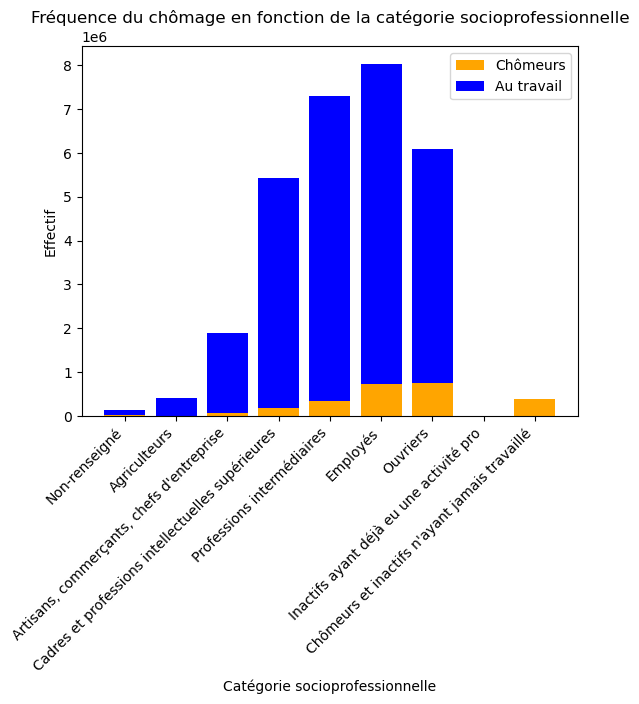

In [14]:
plt.bar(data["CSTOTR"],data["Effectif_chom"], color='orange', label='Chômeurs')
plt.bar(data["CSTOTR"],data["Effectif_emploi"], color='blue', label='Au travail', bottom=data["Effectif_chom"])
plt.title('Fréquence du chômage en fonction de la catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Effectif')
plt.xticks(data["CSTOTR"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## D - Age

In [ ]:
#chômage par âge
#Catégories possibles
categories = ["15-29","30-39","40-49","50-59","60+",]
value = EEC_2019["AGE5"].unique()

#tableau avec AGE/Effectif en emploi/Effectif chômeur tout cela pondéré par EXTRIAN
result_dict = {"AGE5": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["AGE5"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["AGE5"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).sort_values(by="AGE5").reset_index(drop=True)
data

In [ ]:
plt.bar(data["AGE5"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["AGE5"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["AGE5"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction de l'âge")
plt.xlabel('Age')
plt.ylabel('Effectif')
plt.xticks(data["AGE5"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## E - Sexe

In [ ]:
#chômage et inactivité par sexe
#Catégories possibles
categories = ["Homme","Femme"]
value = EEC_2019["SEXE"].unique()

#tableau avec SEXE/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"SEXE": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["SEXE"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["SEXE"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).sort_values(by="SEXE").reset_index(drop=True)
data

In [ ]:
plt.bar(data["SEXE"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["SEXE"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["SEXE"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('SEXE')
plt.ylabel('Effectif')
plt.xticks(data["SEXE"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

## F - Catégorie de commune

In [ ]:
#chômage et inactivité par taille de la commune
#Catégories possibles
categories = ["Grandes aires urbaines","Autres aires","Autres communes multipolarisées","Communes isolées hors influence des pôles"]
value = EEC_2019["CATAU2010R"].unique()

#tableau avec CAUTAU2010R/Effectif en emploi/Effectif chômeur et pour inactifs tout cela pondéré par EXTRIAN
result_dict = {"CATAU2010R": categories, 'Effectif_emploi': [], 'Effectif_chom':[], 'Proportion_chom':[], 'Effectif_inac':[], 'Proportion_inac':[]}  #à chaque valeur on associe la somme des occurences pondérées
for val in value :
    somme_pond_E = EEC_2019[(EEC_2019["CATAU2010R"] == val) & (EEC_2019["ACTEU"]==1)]["EXTRIAN"].sum()
    somme_pond_C = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==2)]["EXTRIAN"].sum()
    somme_pond_I = EEC_2019[(EEC_2019["CATAU2010R"] == val)& (EEC_2019["ACTEU"]==3)]["EXTRIAN"].sum()
    result_dict['Effectif_emploi'].append(round(somme_pond_E,0))
    result_dict['Effectif_chom'].append(round(somme_pond_C,0))
    result_dict['Proportion_chom'].append(round(somme_pond_C/(somme_pond_C + somme_pond_E+somme_pond_I),2))
    result_dict['Effectif_inac'].append(round(somme_pond_I,0))
    result_dict['Proportion_inac'].append(round(somme_pond_I/(somme_pond_I + somme_pond_E+somme_pond_C),2))
data = pd.DataFrame(result_dict).reset_index(drop=True)
data

In [ ]:
plt.bar(data["CATAU2010R"],data["Effectif_emploi"], color='blue', label='Au travail')
plt.bar(data["CATAU2010R"],data["Effectif_chom"], color='orange', label='Chômeurs', bottom=data["Effectif_emploi"])
plt.bar(data["CATAU2010R"],data["Effectif_inac"], color='red', label='Inactifs', bottom=data["Effectif_emploi"] + data["Effectif_chom"])
plt.title("Statut d'activité en fonction du sexe")
plt.xlabel('Catégorie de commune du logement de résidence')
plt.ylabel('Effectif')
plt.xticks(data["CATAU2010R"],categories, rotation=45, ha='right')
plt.legend()
plt.show()

# II - Analyse en composantes principales

## A - Normalisation

Variables à inclure dans la matrice de variance-covariance : ACTEU, SEXE,DIP11, type de ménages, CSTOTR, NFRRED,NBTOTE (heures travaillées usuellement) HPLUSA (nombre d'heures voulues), implication dans la recherche (CONTACT,DEM),accepterait temps partiel, ANCCHOM, AGE5, CATAU2010R ruralité, COURED ENFRED couple

Variables à transformer en indicatrices (attention ne pas mettre toutes les catégories) : ACTEU DIP11, CSTOTR, NFRRED, AGE5, CATAU2010R + plus variables à régler en 0,1

Variables à normaliser : NBTOTE, HPLUSA, ANNCHOM (mettre unité)

In [ ]:
#Création d'une base PCA
EEC_PCA=EEC_2019
EEC_PCA=pd.DataFrame(EEC_PCA[["EXTRIAN","ACTEU","SEXE","DIP11","CSTOTR","NFRRED","NBTOTE","HPLUSA","HHCE","CONTACT",
"ANCCHOM","AGE5","AIDFAM","CATAU2010R","COURED","ENFRED"]]).reset_index(drop=True)
EEC_PCA

In [ ]:
#ACTEU
EEC_PCA["CHOM"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==2, "CHOM"]=1

EEC_PCA["INAC"]=0
EEC_PCA.loc[EEC_PCA["ACTEU"]==3, "INAC"]=1

In [ ]:
#DIP11 que l'on va séparer en indicatrices pour enseignement sup, secondaire et en dessous
EEC_PCA["infcollege"]=0 #infcollege = aucun diplome, certif d'études, brevet
EEC_PCA.loc[EEC_PCA["DIP11"].isin([71,70,60]), "infcollege"]=1

EEC_PCA["secondaireplus"]=0 #secondaire plus = secondaire + BTS et DUT...
EEC_PCA.loc[EEC_PCA["DIP11"].isin([50,42,41,33,31]), "secondaireplus"]=1

EEC_PCA["sup"]=0 #le reste
EEC_PCA.loc[EEC_PCA["DIP11"].isin([30,11,10]), "sup"]=1

In [ ]:
#SEXE (0 = H, 1 = F)
EEC_PCA.loc[EEC_PCA["SEXE"]==1, "SEXE_bin"]=0
EEC_PCA.loc[EEC_PCA["SEXE"]==2, "SEXE_bin"]=1

In [ ]:
#CSTOTR : en se basant sur le graphique ci-dessus, je crée une catégorie employé avec les professions intermédiaires, les employés et les ouvriers
#et je crée une catégorie employeur avec les cadres sups, artisans, chef d'entreprises
EEC_PCA["employe"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([4,5,6]), "employe"]=1

EEC_PCA["employeur"]=0 
EEC_PCA.loc[EEC_PCA["CSTOTR"].isin([2,3]), "employeur"]=1
#on a 3/4 de l'échantillon employe et 1/4 employeur

In [ ]:
#NFRRED : variable indicatrice : "l'individu est-il de nationalité française ?"
EEC_PCA["NAT"]=0
EEC_PCA.loc[EEC_PCA["NFRRED"].isin([1,2]), "NAT"]=1
#1/20 sans nationalité FR

In [ ]:
#AGE5 : transformer en deux indicatrices jeunes actifs (0 à 29 ans) ou actifs âgés (plus de 50 ans)
EEC_PCA["JEUNE"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([00,15]), "JEUNE"]=1

EEC_PCA["ANCIEN"]=0 
EEC_PCA.loc[EEC_PCA["AGE5"].isin([50,60]), "ANCIEN"]=1
#1/5 de jeunes et 1/3 d'anciens

In [ ]:
#CONTACT : contact avec pôle emploi depuis dernière enquête (3 mois), 1 si oui
EEC_PCA["P_E"]=0
EEC_PCA.loc[EEC_PCA["CONTACT"]==1, "P_E"]=1
#moins d'1/20

In [ ]:
#création de metrop. 1 si l'individu habite dans un grande aire urbaine : 4/5 échantillon
EEC_PCA["METROP"]=0
EEC_PCA.loc[EEC_PCA["CATAU2010R"]==1, "METROP"]=1

In [ ]:
#COURED : 1 si l'individu est en couple
EEC_PCA["COUPLE"]=0
EEC_PCA.loc[EEC_PCA["COURED"]==1, "COUPLE"]=1
#2/3 en couple

In [ ]:
#ENFRED : 1 si l'individu a un enfant
EEC_PCA["ENF"]=0
EEC_PCA.loc[EEC_PCA["ENFRED"]==1, "ENF"]=1
#la moitié a un enfant

In [ ]:
#NBTOTE
col = EEC_PCA['NBTOTE']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['NBTOTE'] = colonne_normalisee
EEC_PCA["NBTOTE"].describe()
#très peu d'entrées dans cette variable (à remédier)

In [ ]:
#HPLUSA (beaucoup d'informations manquantes, surtout les personnes ne voulant pas modifier leur charge horraire, on va donc prendre 
#leur charge horraire actuelle comme souhait.
EEC_PCA["HHCE"]=EEC_PCA["HHCE"].fillna(0)
EEC_PCA.loc[EEC_PCA['HPLUSA'].isna(), "HPLUSA"]=EEC_PCA[EEC_PCA['HPLUSA'].isna()]["HHCE"]

In [ ]:
col = EEC_PCA['HPLUSA']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['HPLUSA'] = colonne_normalisee
EEC_PCA["HPLUSA"].describe()

In [ ]:
#ANCCHOM : recodage en mois
EEC_PCA["ANCCH"]=0.0#en emploi
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==1, "ANCCH"]=1.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==2, "ANCCH"]=2.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==3, "ANCCH"]=4.5
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==4, "ANCCH"]=9.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==5, "ANCCH"]=15.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==6, "ANCCH"]=21.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==7, "ANCCH"]=30.0
EEC_PCA.loc[EEC_PCA["ANCCHOM"]==8, "ANCCH"]=40.0
EEC_PCA["ANCCH"].describe()

In [ ]:
col = EEC_PCA['ANCCH']

scaler = MinMaxScaler() # initialiser le scaler MinMax

col_a_norm = col.values.reshape(-1, 1) # convertir la colonne en une matrice 2D (nécessaire pour le scaler)

colonne_normalisee = scaler.fit_transform(col_a_norm)

# Remplacer la colonne originale par la colonne normalisée et remplir NaN
EEC_PCA['ANCCH'] = colonne_normalisee
EEC_PCA["ANCCH"].describe()

## B - Matrice de covariances

In [ ]:
EEC_PCA1=EEC_PCA[['HPLUSA', 'CHOM','INAC', 'infcollege', 'P_E',"ANCCH",
       'secondaireplus', 'sup', 'SEXE_bin', 'employe', 'employeur', 'NAT',
       'JEUNE', 'ANCIEN', 'METROP', 'COUPLE', 'ENF']] #on omet NBTOTE pas assez d'ind.
noms_var=EEC_PCA1.columns
EEC_PCAW=EEC_PCA["EXTRIAN"].to_numpy()
EEC_PCA1.head()

In [ ]:
EEC_COV_NP=np.cov(EEC_PCA1.to_numpy(), rowvar=False, aweights=EEC_PCAW)
EEC_COV=pd.DataFrame(EEC_COV_NP) #matrice de covariance pondérée
EEC_COV.columns = noms_var #on affiche le nom des variables correspondantes en x et y
EEC_COV.set_index(EEC_COV.columns, inplace=True)
EEC_COV

In [ ]:
# Utiliser seaborn pour créer la heatmap
sns.set(style="white")
sns.heatmap(EEC_COV, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

# Afficher la heatmap
plt.title('Heatmap de la Matrice de Covariance')
plt.show()

## C - PCA

In [ ]:
# Appliquer la PCA
pca = PCA()
composantes_principales = pca.fit(EEC_COV).components_

In [ ]:
# Graphique des valeurs propres
valeurs_propres = pca.explained_variance_ratio_
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres)
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Graphique des valeurs propres (Scree Plot)')
plt.show()

In [ ]:
# Sélectionner les deux premiers vecteurs propres
first_pc = composantes_principales[:, 0]
second_pc = composantes_principales[:, 1]
variable_names = EEC_COV.columns.tolist()

# Tracer le graphique de dispersion des deux premières composantes principales
plt.figure(figsize=(10, 6))
plt.scatter(first_pc, second_pc)

# Annoter chaque point avec le nom de la variable
for i, variable in enumerate(variable_names):
    plt.annotate(f'Var {variable}', (first_pc[i], second_pc[i]), color='r', rotation=45)

# Ajouter des labels et un titre au graphique
plt.title('Contribution des variables aux deux premières composantes principales (Matrice de Covariance)')
plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')

# Afficher le graphique
plt.show()

# III - Modélisation

## A - Preprocessing

In [ ]:
# On choisit un ensemble de variables qui ne comprend que données sociodémographiques, géographiques associées à l'individu
# et au ménage étudié et qui sont disponibles sur les deux années étudiées

# Notre variable d'intérêt ici est ACTEU

# Variables à inclure dans le modèle -> AGE3 ;  AGE5 ; ANNEE ;TRIM ;  CATAU2010R ; COURED ;
# DIP11; ENFRED ; METRODOM ; NFRRED ; SEXE ; TYPMEN7 

# Pour la prise en compte de la PCS, il n'est pas possible d'utiliser CSTOT /  CSTOTPRM / CSTOTR
# Ce sont des variables qui distinguent les actifs des non-actifs
# Possibilité de recoder à partir de CSP et CSA

# Meme si les variables sont colinéaires (AGE3, AGE5), on peut les garder et faire en sorte que le predicteur
# choisisse la plus pertinente

list_var_selected = ["ACTEU","ANNEE" ,"TRIM", "AGE3" ,  "AGE5"  , "CATAU2010R" ,
"COURED" ,"CSA" ,"CSP" , "DIP11","ENFRED" , "METRODOM" , "NFRRED" , "SEXE" , "TYPMEN7"]

EEC_2019 = EEC_2019[list_var_selected]
EEC_2020 = EEC_2020[list_var_selected] 

list_var = list(EEC_2019.columns.values)
print(list_var)

### Recodage d'une variable de PCS à deux niveaux regroupant actifs occupés et les autres

In [ ]:
#On commence par vérifier que les variables CSP (actifs occupés) et CSA (non actifs occupés) ne sont pas renseignées pour les mêmes individus

non_nan_csp = EEC_2019['CSP'].notna()
non_nan_csa = EEC_2019['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

In [ ]:
#On peut donc sommer les deux colonnes pour obtenir la valeur voulue
EEC_2019['PCS'] = EEC_2019['CSA'].add(EEC_2019['CSP'], fill_value=0)

pcs_manquante = EEC_2019['PCS'].isna().sum()

print(pcs_manquante)
#1260 valeurs manquantes, donc assez peu

In [ ]:
#Idem pour EEC_2020
#Création d'une variable de PCS avec la PCS des actifs occupés et l'ancienne des inactifs et chômeurs.
non_nan_csp = EEC_2020['CSP'].notna()
non_nan_csa = EEC_2020['CSA'].notna()

# Vérifiez si les variables sont renseignées pour les mêmes individus
positions_differentes = (non_nan_csp != non_nan_csa).any()

# Affichez le résultat
if positions_differentes:
    print("Les variables ne sont pas renseignées pour les mêmes individus")
else:
    print("Les variables sont renseignées pour les mêmes individus")

#On peut donc sommer les deux colonnes
EEC_2020['PCS'] = EEC_2020['CSA'].add(EEC_2020['CSP'], fill_value=0)

pcs_manquante = EEC_2020['PCS'].isna().sum()

print(pcs_manquante)
#864 valeurs manquantes, donc très peu

In [ ]:
#Attention, notre variable 'PCS' contient une modalité en 2019,qui n'existe pas en 2020
#Cela vient de la modalité "10" de la PCS ("agriculteur") qui n'existe pas pour 2020, et uniquement chez des non actifs occupés
#On peut supposer qu'il s'agit d'agriculteurs pour lesquels la taille d'exploitation n'a pu être déterminée...
#Cela ne concerne que deux observations
EEC_2019['PCS'].value_counts()[0]
print(EEC_2019.shape)
#Lors de la conversion de la variable en indicatrice, nous allons donc obtenir des bases de tailles différentes
#pour éviter cela, on décide de supprimer ces deux observations
EEC_2019 = EEC_2019[EEC_2019['PCS'] != 10]
print(EEC_2019.shape)

In [ ]:
#On enlève de la base les variables CSA et CSP
EEC_2019 = EEC_2019.drop(['CSA', 'CSP'], axis=1)
EEC_2020 = EEC_2020.drop(['CSA', 'CSP'], axis=1)

### Analyses des NA de notre base

In [ ]:
#Comptons le nombre de NaN dans nos df
nombre_lignes_nan_2019 = EEC_2019.isnull().any(axis=1).sum()
nombre_lignes_nan_2020 = EEC_2020.isnull().any(axis=1).sum()
print(nombre_lignes_nan_2019)
print(nombre_lignes_nan_2020)

In [ ]:
#Isolons nos observations avec des NAN
EEC_2019_with_nulls = EEC_2019[EEC_2019.isna().any(axis=1)]
EEC_2020_with_nulls = EEC_2020[EEC_2020.isna().any(axis=1)]

In [ ]:
print(EEC_2019_with_nulls.shape)
print(EEC_2020_with_nulls.shape)

In [ ]:
EEC_2019_with_nulls = EEC_2019_with_nulls.copy()
EEC_2019_with_nulls['total_nan'] = EEC_2019_with_nulls.isna().sum(axis=1)

In [ ]:
print(EEC_2019_with_nulls['total_nan'].mean())
#En moyenne, 1,79 valeurs manquantes, sur 14 variables

In [ ]:
#On affiche un tableau avec le nombre de NAN par variable, et le pourcentage des observations manquantes que cela représente
nan_count_variable_2019 = EEC_2019_with_nulls.isna().sum()
print(nan_count_variable_2019)
nan_percentage_variable_2019 = (EEC_2019_with_nulls.isna().sum() / len(EEC_2019_with_nulls)) * 100
print(nan_percentage_variable_2019)
#A chaque fois il nous manque donc le diplôme, et dans environ un tiers des cas la PCS recodée et la variable d'intérêt, un cinquième des nationalités

In [ ]:
#Même chose pour 2020
EEC_2020_with_nulls = EEC_2020_with_nulls.copy()
EEC_2020_with_nulls['total_nan'] = EEC_2020_with_nulls.isna().sum(axis=1)
print(EEC_2020_with_nulls['total_nan'].mean())
#En moyenne, 1,67 valeurs manquantes, sur 14 variables
nan_count_variable_2020 = EEC_2020_with_nulls.isna().sum()
print(nan_count_variable_2020)
nan_percentage_variable_2020 = (EEC_2020_with_nulls.isna().sum() / len(EEC_2020_with_nulls)) * 100
print(nan_percentage_variable_2020)
#On retrouve des choses très semblables sur 2020, avec encore une fois surtout le diplôme qui manque

In [ ]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls.dropna(subset=['ACTEU'])
EEC_2019_with_nulls_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.copy()
EEC_2019_with_nulls_non_ACTEU['total_nan'] = EEC_2019_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2019_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2019_non_ACTEU = EEC_2019_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2019_non_ACTEU)
nan_percentage_variable_2019_non_ACTEU = (EEC_2019_with_nulls_non_ACTEU.isna().sum() / len(EEC_2019_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2019_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

In [ ]:
#Commençons par supprimer les observations pour lesquelles notre variable d'intérêt n'est pas renseignée --> inutilisables
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls.dropna(subset=['ACTEU'])
EEC_2020_with_nulls_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.copy()
EEC_2020_with_nulls_non_ACTEU['total_nan'] = EEC_2020_with_nulls_non_ACTEU.isna().sum(axis=1)
print(EEC_2020_with_nulls_non_ACTEU['total_nan'].mean())
#En moyenne, 1,01 valeurs manquantes, sur 13 variables
nan_count_variable_2020_non_ACTEU = EEC_2020_with_nulls_non_ACTEU.isna().sum()
print(nan_count_variable_2020_non_ACTEU)
nan_percentage_variable_2020_non_ACTEU = (EEC_2020_with_nulls_non_ACTEU.isna().sum() / len(EEC_2020_with_nulls_non_ACTEU)) * 100
print(nan_percentage_variable_2020_non_ACTEU)
#A part une poignée de nationalités, il ne manque plus que le diplôme, pour tout le monde.

In [ ]:
# Il y a très peu de valeurs manquantes dans les variables, 4205 variables concernées en 2019, 3379 en 2020.
#Si on supprime d'office les observations pour lesquelles manquent la variable d'intérêt, on tombe à 2945 et 2515, et c'est systématiquement le diplôme qui manque
#On choisit donc de les supprimer de la base pour le moment
print(EEC_2019.shape)
print(EEC_2020.shape)
EEC_2019 = EEC_2019.dropna() 
EEC_2020 = EEC_2020.dropna() 
print(EEC_2019.shape)
print(EEC_2020.shape)

### Suite et fin du préprocessing

In [ ]:
# Conversion de l'ensemble des variables catégorielles en indicatrices
EEC_2019 = pd.get_dummies(EEC_2019, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS", "DIP11", "NFRRED" , "TYPMEN7"])
EEC_2020 = pd.get_dummies(EEC_2020, columns=["AGE3" ,  "AGE5"  , "CATAU2010R" ,
"PCS" , "DIP11", "NFRRED" , "TYPMEN7"])

#RECODAGE des variables binaires

EEC_2019['EMPLOI'] = EEC_2019['ACTEU'].apply(lambda x: x == 1)
EEC_2020['EMPLOI'] = EEC_2020['ACTEU'].apply(lambda x: x == 1)

EEC_2019['ACTIF'] = EEC_2019['ACTEU'].apply(lambda x: (x == 1) or (x == 2))
EEC_2020['ACTIF'] = EEC_2020['ACTEU'].apply(lambda x: (x == 1) or (x == 2))

EEC_2019['FEMME'] = EEC_2019['SEXE'].apply(lambda x: x == 2)
EEC_2020['FEMME'] = EEC_2020['SEXE'].apply(lambda x: x == 2)

EEC_2019['COUPLE'] = EEC_2019['COURED'].apply(lambda x: x == 2)
EEC_2020['COUPLE'] = EEC_2020['COURED'].apply(lambda x: x == 2)

EEC_2019['ENFANT'] = EEC_2019['ENFRED'].apply(lambda x: x == 2)
EEC_2020['ENFANT'] = EEC_2020['ENFRED'].apply(lambda x: x == 2)


EEC_2019['DOM'] = EEC_2019['METRODOM'].apply(lambda x: x == 2)
EEC_2020['DOM'] = EEC_2020['METRODOM'].apply(lambda x: x == 2)

#On retire les variables non recodées
EEC_2019 = EEC_2019.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)
EEC_2020 = EEC_2020.drop(['METRODOM', 'ENFRED' , 'COURED', 'SEXE',"ACTEU"], axis=1)

# 73 variables
print(EEC_2019.shape)
print(EEC_2020.shape)

#### Création de notre sous-ensemble, et de nos array pour sklearn

In [ ]:
#Pour rendre les calculs plus rapide, on se concentre sur un sous-ensemble
EEC_2019_subsample = EEC_2019.sample(n=10000, random_state=3) 

In [ ]:
# Balanced sample avec prediction emploi
proportion_values = EEC_2019_subsample['EMPLOI'].value_counts(normalize=True)
print(proportion_values)

In [ ]:
# Description d'une feature pour check booléen
variable_description = EEC_2019_subsample["FEMME"].describe()

print(variable_description)

In [ ]:
# On transforme nos dataframes en array car sklearn est bien adapté pour travailler sur ce type de données

# Array contentant l'ensemble des variables explicatives (on exclut donc CHOMAGE/ANNEE/TRIM)
X = np.array(EEC_2019_subsample.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
print(X.shape)

# Array contentant la variable expliquée
y = np.array(EEC_2019_subsample["EMPLOI"])
print(y.shape)

In [ ]:
#création de nos ensemble de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, random_state=4)

## B - Support Vector Machine

Nous essayons ici d'appliquer un modèle de type SVM pour prédire la situation d'emploi à partir des variables socio-démographiques, en essayant de sélectionner le paramètre régularisation qui permet la meilleure précision sur notre (sous)-échantillon de test.

In [ ]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

C_range = np.linspace(0.1, 20, 50)
for param in C_range:
    clf = SVC( C=param, random_state=3)
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

Il semble ici que très vite la performance diminue sur le test, dès des valeurs assez petites du paramètre C, ce qui indique que le modèle de SVM rentre très vite dans une phase de surapprentissage : on s'attends à ce que notre modèle ne sélectionne qu'un nomre limité de variables.

In [ ]:
#utilisation de GridSearch pour trouver le meilleur paramètre de régularisation
params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=SVC( C=params, random_state=3), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

#Calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

Comme attendu, GridSearch nous propose donc un paramètre de régularisation faible, autours de 2,85, avec un score de 0,896, signifiant que 89,6% de nos observations du test sont correctement prédites.

In [ ]:
clf = SVC( C=gs.best_params_['C'], random_state=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

## C - Regression logistique

Nous essayons ici une autre méthode, à savoir la régression logistique

In [ ]:
acc_train, acc_test = list(), list()
f1_train, f1_test = [], []

                        
C_range = np.linspace(0.1, 20, 50)

for param in C_range:
    clf = LogisticRegression(C=param,random_state=3, penalty="l1",solver='liblinear' )
    clf.fit(X_train, y_train)
    acc_train.append(clf.score(X_train, y_train))
    acc_test.append(clf.score(X_test, y_test))
    
    y_pred_train = clf.predict(X_train)
    f1_train.append(f1_score(y_train, y_pred_train, average='binary'))  
    
    y_pred_test = clf.predict(X_test)
    f1_test.append(f1_score(y_test, y_pred_test, average='binary'))
    
plt.figure(figsize=(10, 5))

plt.plot(C_range, f1_train, label='F1 score train', lw=6)
plt.plot(C_range, f1_test, label='F1 score test', lw=6)

plt.plot(C_range, acc_train, label='Accuracy train ', lw=6)
plt.plot(C_range, acc_test, label='Accuracy test', lw=6)

plt.legend(loc='best', fontsize=12)

plt.xlabel("C", fontweight="bold", fontsize=20)
plt.ylabel("Performance", fontweight="bold", fontsize=20)
plt.xticks(fontweight="bold", fontsize=15)
plt.yticks(fontweight="bold", fontsize=15)
plt.tight_layout()

plt.show()

#TOUJOURS GRAPH UN PEU BIZARRE -> PQ PERFORMANCE MEILLEURE SUR TEST QUE SUR TRAIN??? 
#Ce problème disparait dès lors que l'on se place avec uneautre répartition train/test (j'ai changé la seed)
# Pas de diminution de la performance quand regularisation diminue?

In [ ]:
# Processus de cross-validation qui découpe notre échantillon en 5 et détermine le paramètre de régularisation optimal
# ATTENTION -> gain de selection des paramètres via cross validation est marginal par rapport à la selection des bonnes variables 
# On utilise GridSearch ici parce qu'on veut combiner plusieurs paramètres

#  By default, scikit-learn's GridSearchCV does not select the most parsimonious model (fewer features)
# when multiple models have equal scores. GridSearchCV uses the mean cross-validated score to select
# the best model based on the specified scoring metric.
# If there are multiple models with the same highest mean score, GridSearchCV selects
# the one with the smallest value of the parameters.

# If we want to select the most parsimonious model among those with equal scores,
# you may need to implement a custom scoring function

params= { 'C':np.linspace(0.001, 5, 50) }
gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

results_df = pd.DataFrame(gs.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score']])

In [ ]:
# On refait meme process en jouant en + sur le critère de penalty et le tol
# tol = tolerance for stopping criteria. It defines the stopping criterion for the solver to converge to a solution.

params= { 'C':np.linspace(0.001, 5, 50),'tol': [0.01, 0.1, 1, 10] }


gs = GridSearchCV(estimator=LogisticRegression(random_state=3, penalty ="l1",  solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train, y_train)

# calcule accuracy du meilleur model trouvé par grid search sur le sample choisi
print(gs.best_params_)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

Le modèle choisit atteint une précision de l'ordre de 86,5% sur le test, ce qui est légérement moins efficace que le modèle SVMde la partie précédente

In [ ]:
clf = LogisticRegression( tol=gs.best_params_['tol'], C=gs.best_params_['C'], random_state=3,
                         penalty ="l1", solver='liblinear')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [ ]:
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)
#Conserve la grande majorité des variables

## D - Selections de variables

In [ ]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

# X transform contient un nombre réduit de caractéristiques basé sur la sélection
# des caractéristiques par régression Lasso
sfm.fit(X,y)
X_transform = sfm.transform(X)
print("Transformed data shape:", X_transform.shape)
print("Original data shape:", X.shape)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform, 
                                                    y, 
                                                    test_size=.2, random_state=4)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }



gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

print(gs.best_params_)
print(gs.score(X_train_2, y_train_2))
print(gs.score(X_test_2, y_test_2))

#Perd un peu en performance avec 10 variables max

In [ ]:
clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

In [ ]:
#Identify the indices of the variables used for prediction in X_transform
variables_indices = np.where(np.abs(clf.coef_) > 1e-10)[1]

X_transform_useful_variables = X_transform[:,variables_indices]

# X_transform n'a pas les meme indices pour les colonnes que X ou EEC_2019 -> Je verifie quelle colonne a les meme 
# valeurs
for j in range(X_transform_useful_variables.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_useful_variables[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column  is equal to the {column_name} column in EEC_2019_subsample")

In [ ]:
# J'essaie de reconstruire la variable predite à partir des variables et des coefs associés
linear_pred_3 = clf.intercept_ + np.dot(X_test_2[:, variables_indices], clf.coef_[:, variables_indices].T) 
y_pred_3 = 1 / (1 + np.exp(-linear_pred_3))
threshold = 0.5  
y_pred_3_binary = (y_pred_3 > threshold).astype(bool).ravel()

comparison = np.equal(y_pred_2, y_pred_3_binary)
equal_predictions = np.sum(comparison)
percentage_equal = (equal_predictions / len(y_pred_2)) * 100 
print("% same predictor",percentage_equal)

## E - Prediction actifs/inactifs

Nous pensons qu'une partie du problème de prédiction réside dans la distinction entre certains chômeurs de courte durée et actifs occupés. Afin de vérifier cela,  nous construisons un prédicteur du fait d'être actif et comparons la qualité de la prediction.


In [ ]:
# Array contentant la variable expliquée
y_bis = np.array(EEC_2019_subsample["ACTIF"])
print(y_bis.shape)

print(y_bis[:10])

In [ ]:
y_pred = clf.predict(X_transform)

cm= confusion_matrix(y_bis,y_pred)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

# Prédicteur de l'emploi déjà très bon pour prédire actif/pas actif => logique

In [ ]:
#  Lasso linear model with cross-validated selection of the regularization parameter (alpha) to find the optimal
clf = LassoCV()
clf.fit(X, y_bis)

# Je m'impose un maximum de 10 features selectionnées
sfm = SelectFromModel(clf, prefit=False, max_features=10)

sfm.fit(X,y_bis)

X_transform_bis = sfm.transform(X)
print(X_transform_bis.shape)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_transform_bis, 
                                                    y_bis, 
                                                    test_size=.2, random_state=3)


params= { 'C':np.linspace(0.001, 1, 50), 'tol': [0.01, 0.1, 1, 10] }

gs = GridSearchCV(estimator=LogisticRegression( random_state=3, penalty = "l1", solver='liblinear'), 
                   param_grid=params,
                   cv=5)

gs.fit(X_train_2, y_train_2)

clf = LogisticRegression(tol=gs.best_params_['tol'], C=gs.best_params_['C'],
                         random_state=3, penalty="l1", solver='liblinear')

clf.fit(X_train_2, y_train_2)
y_pred_2 = clf.predict(X_test_2)

cm= confusion_matrix(y_test_2, y_pred_2)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

print(clf.coef_)
num_variables = np.sum(np.abs(clf.coef_) > 1e-10)
print("Number of variables considered:", num_variables)

La qualité de la prediction est meilleure puisqu'on passe de 269 (197 + 72) erreurs de prédictions de l'emploi à 209 (117 + 92) erreurs de prédictions du statut actif.

In [ ]:
#=> ON dirait que les indices des colonnes change lorsqu'on passe de X à X_transform
# => ['AGE3_15' 'AGE3_30' 'AGE3_50'] ne sont pas les "bonnes" variables
# Iterate over a range of columns in X_transform_bis
for j in range(X_transform_bis.shape[1]):
    for column_name in EEC_2019_subsample.columns:
        # Check if the corresponding column in X_transform_bis has equal values
        is_equal = np.all(X_transform_bis[:, j] == EEC_2019_subsample[column_name].values)
        
        if is_equal:
            print(f"The {j+1} column in X_transform_bis is equal to the {column_name} column in EEC_2019_subsample")

In [ ]:
y_pred_4 = clf.predict(X_transform_bis)

cm= confusion_matrix(y_bis,y_pred_4)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()

In [ ]:
X_2020 = np.array(EEC_2020.drop(columns=["ACTIF","EMPLOI","ANNEE", "TRIM"]))
y_2020 = np.array(EEC_2020["ACTIF"])

X_2020_transform = sfm.transform(X_2020)
print(X_2020_transform.shape)

y_pred_2020 = clf.predict(X_2020_transform)


cm= confusion_matrix(y_2020,y_pred_2020)
disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=clf.classes_
       )
disp.plot()